In [270]:
import requests
import os
import time
from datetime import datetime, timezone
import pandas as pd
import schedule
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, make_scorer, confusion_matrix, classification_report
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import RandomizedSearchCV


In [21]:
RAPID_API_KEY = os.getenv("RAPID_API_KEY")

API_HOST = "adsbexchange-com1.p.rapidapi.com"

URL_TEMP = "https://{HOST}/v2/lat/{LAT}/lon/{LONG}/dist/{DIST}/"

headers = {
    "x-rapidapi-key":RAPID_API_KEY,
    "x-rapidapi-host":API_HOST
}

# Define area of interest

LATITUDE = 27.842490
LONGITUDE = -82.503222
DISTANCE = 50

#initialize database to get data

DATA_DIR = "adsb_data"
os.makedirs(DATA_DIR, exist_ok=True) #creates new directory if needed, otherwise does nothing

#Initialize databse for data with differing number of columns, (or that doesn't fit with focus features)
BAD_DATA_DIR = "adsb_data/weird_data"
os.makedirs(BAD_DATA_DIR, exist_ok=True)

#create a function to get and store data

def get_n_store():
    """Construct API call"""
    api_url = URL_TEMP.format(HOST = API_HOST, LAT = LATITUDE, LONG = LONGITUDE, DIST = DISTANCE)

    headers = {
        "x-rapidapi-key":RAPID_API_KEY,
        "x-rapidapi-hooost":API_HOST
    }

    focus_features = ['hex', 'flight', 't', 'category', 'alt_baro', 'alt_geom', 'gs',
       'track', 'baro_rate','geom_rate', 'emergency', 'lat', 'lon',
       'nac_p', 'nac_v','alert','seen', 'nav_altitude_mcp',
       'nav_heading', 'true_heading']

    try:
        response = requests.get(api_url,headers=headers)
        #Parse response
        adsb_data = response.json().get("ac",[])

        if not adsb_data:
            return(f"{datetime.now(timezone.utc)}: No data returned.")
        """Try to get only the features we're interested in, and make sure that 
        there are a correct number of columns."""
        
        try:
            df = pd.DataFrame(adsb_data).loc[:, focus_features]
            bad_data_path = os.path.join(BAD_DATA_DIR, "bad_data.csv")
            
            if (df.columns != focus_features).all():
                #Don't want to waste an api call on data that's missing a column or two
                df_weird = pd.DataFrame(adsb_data)
                df_weird['timestamp'] = datetime.now(timezone.utc)

                if not os.path.isfile(bad_data_path):
                    df_weird.to_csv(bad_data_path, index=False, mode="w",header=True)
                else:
                    df_weird.to_csv(bad_data_path, index=False, mode="a", header=False)

        except Exception as e:
            print(f"Feature selection error: {e}")

        if not df.shape[1] == 20:
            return("df.shape[1] != 20")
        
        df['timestamp'] = datetime.now(timezone.utc)
        df['mph'] = (df['gs'] * 1.151)

        file_path = os.path.join(DATA_DIR, "adsb_data.csv")

        if not os.path.isfile(file_path):
            df.to_csv(file_path, index=False, mode="w",header=True)
        else:
            df.to_csv(file_path, index=False, mode="a", header=False)

        print(f"{datetime.now(timezone.utc)}: Data fetched and stored!")


    except Exception as e:
        #returns the error with the time it occurred
        return(f'{datetime.now(timezone.utc)}: An error occured: ({e})')

logistic regression
svm classifier

decision tree classifier
random forest classifier

ensemble methods

KNN

Naive Bayes

ADAboost

perceptron

PCA --> could use it technically, but might not be as useful here

Linear and quadratic discriminant analysis
- lots of features so maybe leaning towards quadratic

CNN (tensorflow)

Markov models
- might be a rabbit hole

Hugging face reinforcement learning

kmeans
dbscan

Encoding outcome (category variable) ideas
1. Can encode each variable and keep weight difference ratio the same (ie. A1 = 1, A2 = 3 bc A2 avg weight is 3x bigger than A1)
2. Just label encode the variable as 0,1,2,3 ... 

In [121]:
file = pd.read_csv("./adsb_data/adsb_data.csv") 

/var/folders/1k/3mrcqp5d4670v77qsx12xwmm0000gn/T/ipykernel_59380/1101544825.py:2: DtypeWarning: Columns (3,4,8,9,11,15,16,17,19) have mixed types. Specify dtype option on import or set low_memory=False.
  combined_df = pd.read_csv("./adsb_data/combined_df.csv")


In [59]:
print(len(file))


37068


In [97]:
file.columns

Index(['hex', 'flight', 't', 'category', 'alt_baro', 'alt_geom', 'gs', 'track',
       'baro_rate', 'geom_rate', 'emergency', 'lat', 'lon', 'nac_p', 'nac_v',
       'alert', 'seen', 'nav_altitude_mcp', 'nav_heading', 'true_heading',
       'timestamp', 'mph'],
      dtype='object')

In [98]:
file.head()

,hex,flight,t,category,alt_baro,alt_geom,gs,track,baro_rate,geom_rate,...,lon,nac_p,nac_v,alert,seen,nav_altitude_mcp,nav_heading,true_heading,timestamp,mph
0,a98bef,N714LM,C525,A1,16025,16825.0,316.9,155.78,-2496.0,NaN,...,-83.162519,10.0,2.0,0.0,0.0,12992.0,NaN,NaN,2024-10-01 19:41:01.080409+00:00,364.7519
1,a8d600,DAL1196,B752,A4,38000,40225.0,466.0,3.81,64.0,NaN,...,-83.133703,10.0,2.0,0.0,0.2,38016.0,4.92,NaN,2024-10-01 19:41:01.080409+00:00,536.3660
2,a9036a,N680CA,BE20,A1,6025,6250.0,191.4,63.30,0.0,NaN,...,-83.105868,10.0,2.0,0.0,0.1,6016.0,NaN,NaN,2024-10-01 19:41:01.080409+00:00,220.3014
3,a416be,UAL2246,B738,A3,30125,32025.0,440.2,162.14,-2112.0,NaN,...,-83.078506,8.0,1.0,0.0,0.0,27008.0,130.08,NaN,2024-10-01 19:41:01.080409+00:00,506.6702
4,a88b70,N65LW,C25B,A1,7575,7850.0,243.6,156.28,NaN,-1600.0,...,-83.022542,10.0,1.0,0.0,0.1,6016.0,180.00,NaN,2024-10-01 19:41:01.080409+00:00,280.3836


In [99]:
file.nunique()

print((file['category'].unique()))

#can convert nan's to A0 because they give us the same amount

file[pd.isna(file['category'])]



['A1' 'A4' 'A3' 'A2' 'A7' 'A5' nan 'A0' 'A6' 'B4' 'B1' 'B6' 'B2']


,hex,flight,t,category,alt_baro,alt_geom,gs,track,baro_rate,geom_rate,...,lon,nac_p,nac_v,alert,seen,nav_altitude_mcp,nav_heading,true_heading,timestamp,mph
86,a7ce1b,NaN,C172,NaN,2550,NaN,101.0,80.00,-27.0,NaN,...,-82.495652,NaN,NaN,0.0,0.0,NaN,NaN,NaN,2024-10-01 19:57:19.085041+00:00,116.2510
141,a9da15,NaN,C172,NaN,2100,2075.0,106.3,168.06,64.0,NaN,...,-82.497236,NaN,0.0,0.0,10.4,NaN,NaN,NaN,2024-10-01 20:02:20.940726+00:00,122.3513
206,~2a2f64,NaN,NaN,NaN,2500,4875.0,56.5,256.70,NaN,192.0,...,-82.452393,6.0,0.0,0.0,0.7,NaN,NaN,NaN,2024-10-01 20:07:23.235190+00:00,65.0315
267,a2d56f,CNS613,PC24,NaN,ground,NaN,10.8,155.00,NaN,NaN,...,-82.544740,8.0,NaN,NaN,0.3,NaN,NaN,241.88,2024-10-01 20:26:36.214546+00:00,12.4308
275,~2a322e,NaN,NaN,NaN,800,NaN,69.4,138.50,NaN,384.0,...,-82.445915,0.0,0.0,0.0,49.6,NaN,NaN,NaN,2024-10-01 20:26:36.214546+00:00,79.8794
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36785,~293d86,NaN,NaN,NaN,500,1275.0,73.8,40.60,NaN,0.0,...,-82.356473,6.0,0.0,0.0,7.6,NaN,NaN,NaN,2024-10-15 13:12:06.619922+00:00,84.9438
36828,~2a0796,NaN,NaN,NaN,500,NaN,60.8,189.46,NaN,-576.0,...,-81.646852,0.0,0.0,0.0,0.6,NaN,NaN,NaN,2024-10-15 13:12:06.619922+00:00,69.9808
36876,a84872,NaN,C150,NaN,1200,NaN,77.8,52.84,-128.0,NaN,...,-82.163355,NaN,0.0,0.0,55.0,NaN,NaN,NaN,2024-10-15 13:17:07.854646+00:00,89.5478
37015,ad1dbf,N944TT,C172,NaN,1375,NaN,97.2,356.46,-12.0,-64.0,...,-82.468687,NaN,NaN,0.0,0.0,NaN,NaN,NaN,2024-10-15 13:42:15.443099+00:00,111.8772


In [122]:
category_to_num = {
    'A0': 0,
    'A1': 1,
    'A2': 3,
    'A3': 14,
    'A4': 15,
    'A5': 20,
    'A6': 16,
    'A7': 10,
    'B1': 2,
    'B2': 2,
    'B6': 2,
    'B4': 2
}
file['category'] = file.category.map(category_to_num)
file[file['category'].isna()] = 0
print(file.category.isna().sum())
file

/var/folders/1k/3mrcqp5d4670v77qsx12xwmm0000gn/T/ipykernel_59380/2791515482.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(file.corr(), annot=True, cmap="coolwarm", vmin=-1, vmax=1)


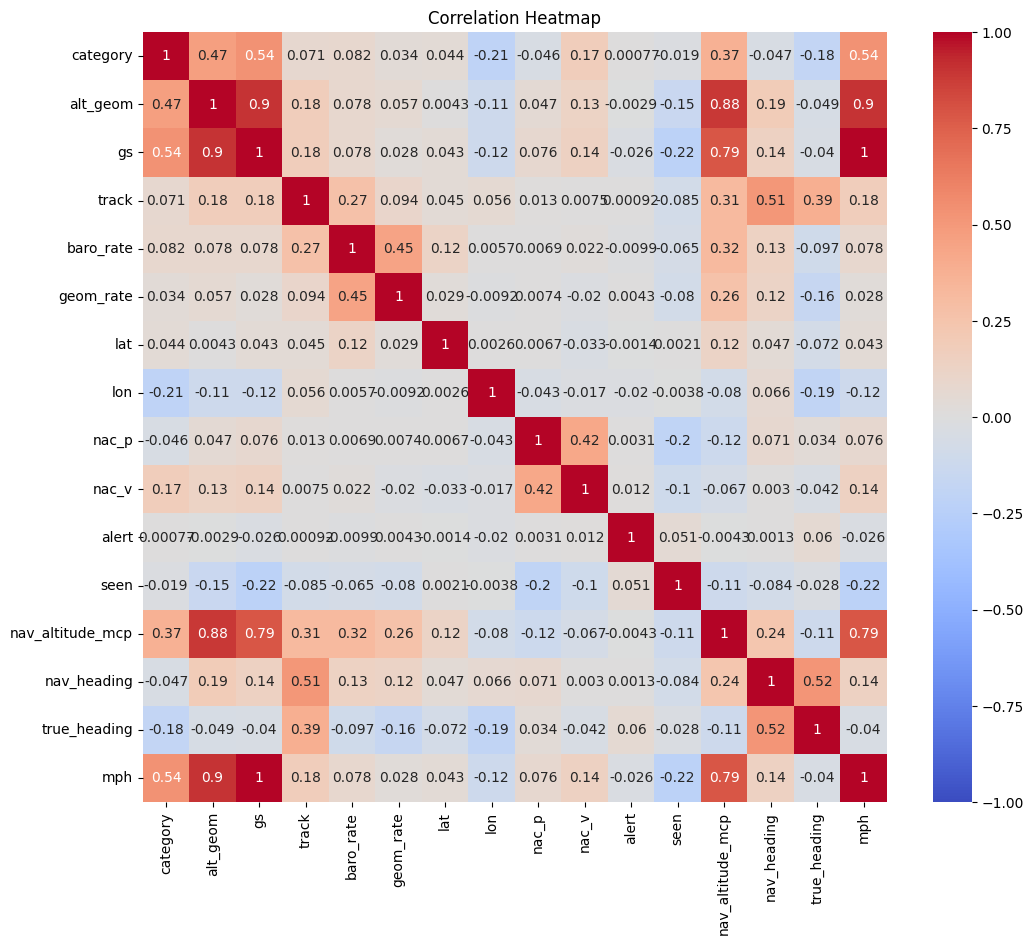

In [139]:
plt.figure(figsize=(12, 10))
sns.heatmap(file.corr(), annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Heatmap")
plt.show()

In [317]:
df = pd.read_csv("./adsb_data/preprocessed_ads_b_data.csv")

In [318]:
df.info()
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34790 entries, 0 to 34789
Data columns (total 28 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   lon               34790 non-null  float64
 1   emergency         34790 non-null  int64  
 2   flight            34790 non-null  int64  
 3   nac_p             34790 non-null  float64
 4   gs                34790 non-null  float64
 5   t                 34790 non-null  int64  
 6   alert             34790 non-null  int64  
 7   baro_rate         34790 non-null  float64
 8   alt_baro          34790 non-null  float64
 9   track             34790 non-null  float64
 10  hex               34790 non-null  int64  
 11  alt_geom          34790 non-null  float64
 12  lat               34790 non-null  float64
 13  geom_rate         34790 non-null  float64
 14  nav_altitude_mcp  34790 non-null  float64
 15  nac_v             34790 non-null  float64
 16  0                 34790 non-null  float6

,lon,emergency,flight,nac_p,gs,t,alert,baro_rate,alt_baro,track,...,2,3,4,5,6,7,8,9,10,11
0,-83.193970,2,3868,10.0,442.4,199,2,-1664.000000,30200.0,152.10,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-83.099318,2,1686,10.0,225.6,163,2,-1536.000000,8300.0,134.46,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-83.092610,2,1309,10.0,350.1,9,2,-2304.000000,13925.0,150.95,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-83.027505,2,5064,10.0,368.9,46,2,-2368.000000,11925.0,150.79,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-82.925439,2,170,9.0,259.5,47,2,-1792.000000,5475.0,163.66,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34785,-81.691966,2,2302,10.0,119.1,93,3,47.531835,6500.0,319.09,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
34786,-81.689054,2,1200,10.0,452.3,164,3,0.000000,36000.0,342.37,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
34787,-81.618831,2,5573,10.0,375.3,163,3,1216.000000,31400.0,2.14,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
34788,-81.608155,2,1220,10.0,115.1,90,3,0.000000,5400.0,168.98,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [319]:
df.iloc[:,25].sum()

1.0

In [320]:
df['category'] = df[df.columns[28-12:28]].idxmax(axis=1).astype('float64')

In [321]:
num_to_num = {
    0: 0,
    1: 1,
    2: 3,
    3: 14,
    4: 15,
    5: 20,
    6: 16,
    7: 10,
    8: 2,
    9: 2,
    11: 2,
    10: 2
}

df['category'] = df.category.map(num_to_num).astype('float64')
df.category

0        14.0
1         3.0
2        14.0
3        14.0
4        14.0
         ... 
34785     1.0
34786    14.0
34787     3.0
34788     1.0
34789     1.0
Name: category, Length: 34790, dtype: float64

In [322]:
df.drop(df.columns[28-12:28], axis=1, inplace=True)
df

,lon,emergency,flight,nac_p,gs,t,alert,baro_rate,alt_baro,track,hex,alt_geom,lat,geom_rate,nav_altitude_mcp,nac_v,category
0,-83.193970,2,3868,10.0,442.4,199,2,-1664.000000,30200.0,152.10,4291,31975.0,27.791428,-11.597031,11008.000000,2.0,14.0
1,-83.099318,2,1686,10.0,225.6,163,2,-1536.000000,8300.0,134.46,1861,8550.0,27.873385,-11.597031,3008.000000,2.0,3.0
2,-83.092610,2,1309,10.0,350.1,9,2,-2304.000000,13925.0,150.95,3701,14525.0,28.563309,-11.597031,11008.000000,4.0,14.0
3,-83.027505,2,5064,10.0,368.9,46,2,-2368.000000,11925.0,150.79,2408,12425.0,28.458640,-11.597031,11008.000000,2.0,14.0
4,-82.925439,2,170,9.0,259.5,47,2,-1792.000000,5475.0,163.66,4417,5600.0,27.779396,-11.597031,3008.000000,1.0,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34785,-81.691966,2,2302,10.0,119.1,93,3,47.531835,6500.0,319.09,884,6675.0,28.003219,-64.000000,14137.141991,2.0,1.0
34786,-81.689054,2,1200,10.0,452.3,164,3,0.000000,36000.0,342.37,857,37975.0,27.569259,-11.597031,36000.000000,2.0,14.0
34787,-81.618831,2,5573,10.0,375.3,163,3,1216.000000,31400.0,2.14,1407,33175.0,27.582825,-11.597031,35008.000000,3.0,3.0
34788,-81.608155,2,1220,10.0,115.1,90,3,0.000000,5400.0,168.98,4389,5650.0,27.675293,-11.597031,5504.000000,2.0,1.0


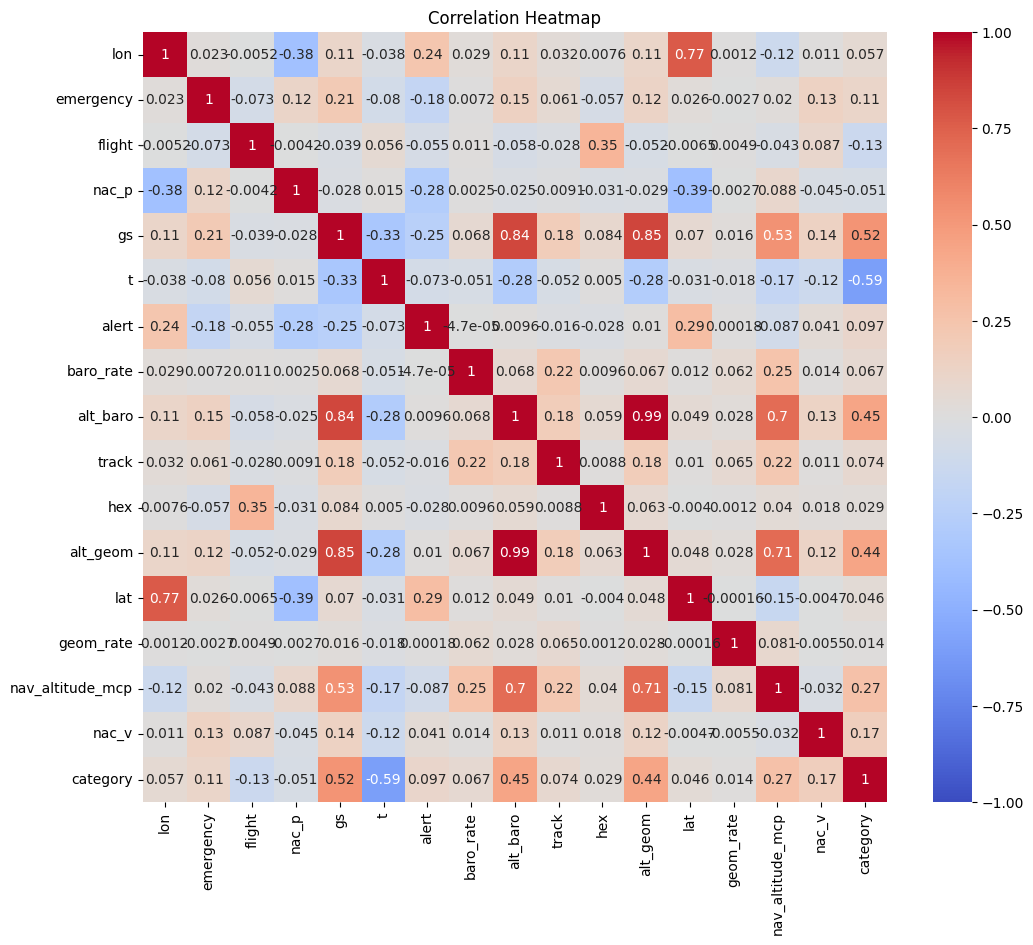

In [209]:
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Heatmap")
plt.show()

In [326]:
X = df.iloc[:,0:16]
y = df['category']

In [345]:
X.columns

Index(['lon', 'emergency', 'flight', 'nac_p', 'gs', 't', 'alert', 'baro_rate',
       'alt_baro', 'track', 'hex', 'alt_geom', 'lat', 'geom_rate',
       'nav_altitude_mcp', 'nac_v'],
      dtype='object')

In [253]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

model_accuracy_titanic_compare_piped = {}

def piped_traineval(
    mod, scaler, x_train_features, y_train_labels, x_test_features, y_test_labels
):
    if scaler:
        pipe = make_pipeline(scaler, mod)
    else:
        pipe = mod
    pipe.fit(x_train_features, y_train_labels)
    y_pred = pipe.predict(x_test_features)
    accuracy = accuracy_score(y_test_labels, y_pred)
    f1 = f1_score(y_pred, y_test_labels, average="weighted")

    if mod.__class__.__name__ == "SVC":
        model_key = (
            f"{mod.__class__.__name__} ({mod.kernel}) - {scaler.__class__.__name__}"
        )
    else:
        model_key = f"{mod.__class__.__name__} - {scaler.__class__.__name__}"

    model_accuracy_titanic_compare_piped[model_key] = [accuracy, f1]

    return accuracy

In [328]:
print(y_train.unique())

[ 1.  3. 14. 10.  0. 15. 20.  2. 16.]


In [254]:
# logistic regression
lr_mod = LogisticRegression()

piped_traineval(lr_mod, StandardScaler(), X_train, y_train, X_test, y_test)
piped_traineval(lr_mod, MinMaxScaler(), X_train, y_train, X_test, y_test)
piped_traineval(lr_mod, RobustScaler(), X_train, y_train, X_test, y_test)

model_accuracy_titanic_compare_piped

/Users/lukewilsen/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/lukewilsen/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#l

{'LogisticRegression - StandardScaler': [0.7947042940510408,
  0.8199843348506114],
 'LogisticRegression - MinMaxScaler': [0.7887814650291787, 0.8252141811490892],
 'LogisticRegression - RobustScaler': [0.5011758557616932, 0.5452694546055499]}

In [255]:
# SVM classifier
svc_mod = SVC()

piped_traineval(svc_mod, StandardScaler(), X_train, y_train, X_test, y_test)
piped_traineval(svc_mod, MinMaxScaler(), X_train, y_train, X_test, y_test)
piped_traineval(svc_mod, RobustScaler(), X_train, y_train, X_test, y_test)

model_accuracy_titanic_compare_piped

{'LogisticRegression - StandardScaler': [0.7947042940510408,
  0.8199843348506114],
 'LogisticRegression - MinMaxScaler': [0.7887814650291787, 0.8252141811490892],
 'LogisticRegression - RobustScaler': [0.5011758557616932, 0.5452694546055499],
 'SVC (rbf) - StandardScaler': [0.8632523299364167, 0.8803219954382083],
 'SVC (rbf) - MinMaxScaler': [0.8516679731730685, 0.8688666481756382],
 'SVC (rbf) - RobustScaler': [0.5309642017245885, 0.6832287094114783]}

In [256]:
# RF
rf_mod = RandomForestClassifier()

piped_traineval(rf_mod, StandardScaler(), X_train, y_train, X_test, y_test)
piped_traineval(rf_mod, MinMaxScaler(), X_train, y_train, X_test, y_test)
piped_traineval(rf_mod, RobustScaler(), X_train, y_train, X_test, y_test)

model_accuracy_titanic_compare_piped

{'LogisticRegression - StandardScaler': [0.7947042940510408,
  0.8199843348506114],
 'LogisticRegression - MinMaxScaler': [0.7887814650291787, 0.8252141811490892],
 'LogisticRegression - RobustScaler': [0.5011758557616932, 0.5452694546055499],
 'SVC (rbf) - StandardScaler': [0.8632523299364167, 0.8803219954382083],
 'SVC (rbf) - MinMaxScaler': [0.8516679731730685, 0.8688666481756382],
 'SVC (rbf) - RobustScaler': [0.5309642017245885, 0.6832287094114783],
 'RandomForestClassifier - StandardScaler': [0.962808117759777,
  0.9636293928098855],
 'RandomForestClassifier - MinMaxScaler': [0.9637662224544901,
  0.9645331208299467],
 'RandomForestClassifier - RobustScaler': [0.9629823186133613,
  0.9637402825610337]}

In [257]:
# KNN
knn_mod = KNeighborsClassifier(n_neighbors=5)

piped_traineval(knn_mod, StandardScaler(), X_train, y_train, X_test, y_test)
piped_traineval(knn_mod, MinMaxScaler(), X_train, y_train, X_test, y_test)
piped_traineval(knn_mod, RobustScaler(), X_train, y_train, X_test, y_test)

model_accuracy_titanic_compare_piped

{'LogisticRegression - StandardScaler': [0.7947042940510408,
  0.8199843348506114],
 'LogisticRegression - MinMaxScaler': [0.7887814650291787, 0.8252141811490892],
 'LogisticRegression - RobustScaler': [0.5011758557616932, 0.5452694546055499],
 'SVC (rbf) - StandardScaler': [0.8632523299364167, 0.8803219954382083],
 'SVC (rbf) - MinMaxScaler': [0.8516679731730685, 0.8688666481756382],
 'SVC (rbf) - RobustScaler': [0.5309642017245885, 0.6832287094114783],
 'RandomForestClassifier - StandardScaler': [0.962808117759777,
  0.9636293928098855],
 'RandomForestClassifier - MinMaxScaler': [0.9637662224544901,
  0.9645331208299467],
 'RandomForestClassifier - RobustScaler': [0.9629823186133613,
  0.9637402825610337],
 'KNeighborsClassifier - StandardScaler': [0.8858984409023605,
  0.8906778550197474],
 'KNeighborsClassifier - MinMaxScaler': [0.9015765177249369,
  0.9054862103957153],
 'KNeighborsClassifier - RobustScaler': [0.8021949307551607,
  0.8162068712161449]}

In [258]:
# ADAboost
ada_mod = AdaBoostClassifier(n_estimators= 50,
                             learning_rate= 1)

piped_traineval(ada_mod, StandardScaler(), X_train, y_train, X_test, y_test)
piped_traineval(ada_mod, MinMaxScaler(), X_train, y_train, X_test, y_test)
piped_traineval(ada_mod, RobustScaler(), X_train, y_train, X_test, y_test)

model_accuracy_titanic_compare_piped

/Users/lukewilsen/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/lukewilsen/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/lukewilsen/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'LogisticRegression - StandardScaler': [0.7947042940510408,
  0.8199843348506114],
 'LogisticRegression - MinMaxScaler': [0.7887814650291787, 0.8252141811490892],
 'LogisticRegression - RobustScaler': [0.5011758557616932, 0.5452694546055499],
 'SVC (rbf) - StandardScaler': [0.8632523299364167, 0.8803219954382083],
 'SVC (rbf) - MinMaxScaler': [0.8516679731730685, 0.8688666481756382],
 'SVC (rbf) - RobustScaler': [0.5309642017245885, 0.6832287094114783],
 'RandomForestClassifier - StandardScaler': [0.962808117759777,
  0.9636293928098855],
 'RandomForestClassifier - MinMaxScaler': [0.9637662224544901,
  0.9645331208299467],
 'RandomForestClassifier - RobustScaler': [0.9629823186133613,
  0.9637402825610337],
 'KNeighborsClassifier - StandardScaler': [0.8858984409023605,
  0.8906778550197474],
 'KNeighborsClassifier - MinMaxScaler': [0.9015765177249369,
  0.9054862103957153],
 'KNeighborsClassifier - RobustScaler': [0.8021949307551607,
  0.8162068712161449],
 'AdaBoostClassifier - Stand

In [259]:
# Naive Bayes
nb_mod = GaussianNB()

piped_traineval(nb_mod, StandardScaler(), X_train, y_train, X_test, y_test)
piped_traineval(nb_mod, MinMaxScaler(), X_train, y_train, X_test, y_test)
piped_traineval(nb_mod, RobustScaler(), X_train, y_train, X_test, y_test)

model_accuracy_titanic_compare_piped

{'LogisticRegression - StandardScaler': [0.7947042940510408,
  0.8199843348506114],
 'LogisticRegression - MinMaxScaler': [0.7887814650291787, 0.8252141811490892],
 'LogisticRegression - RobustScaler': [0.5011758557616932, 0.5452694546055499],
 'SVC (rbf) - StandardScaler': [0.8632523299364167, 0.8803219954382083],
 'SVC (rbf) - MinMaxScaler': [0.8516679731730685, 0.8688666481756382],
 'SVC (rbf) - RobustScaler': [0.5309642017245885, 0.6832287094114783],
 'RandomForestClassifier - StandardScaler': [0.962808117759777,
  0.9636293928098855],
 'RandomForestClassifier - MinMaxScaler': [0.9637662224544901,
  0.9645331208299467],
 'RandomForestClassifier - RobustScaler': [0.9629823186133613,
  0.9637402825610337],
 'KNeighborsClassifier - StandardScaler': [0.8858984409023605,
  0.8906778550197474],
 'KNeighborsClassifier - MinMaxScaler': [0.9015765177249369,
  0.9054862103957153],
 'KNeighborsClassifier - RobustScaler': [0.8021949307551607,
  0.8162068712161449],
 'AdaBoostClassifier - Stand

In [263]:
# Define the parameter grid for Random Forest
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],              # Number of trees
    'max_depth': [10, 20, 30, 40, None],                     # Maximum depth of the trees
    'min_samples_split': [2, 5, 10],                         # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],                           # Minimum number of samples required to be at a leaf node
    'bootstrap': [True, False]                               # Whether bootstrap samples are used when building trees
}

# Set up the RandomizedSearchCV with cross-validation
rf_random = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=param_dist,
    n_iter=50,  # Number of random iterations to perform
    cv=3,  # 3-fold cross-validation
    verbose=2,  # For detailed output
    random_state=42,
    n_jobs=-1,  # Use all available cores
    scoring=make_scorer(accuracy_score)
)

# Fit the randomized search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] END bootstrap=True, max_depth=30, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=  20.8s
[CV] END bootstrap=True, max_depth=30, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=  21.1s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   6.6s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   4.6s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=  32.7s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=  32.7s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=  33.0s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500]},
                   random_state=42,
                   scoring=make_scorer(accuracy_score, response_method='predict'),
                   verbose=2)

In [265]:
print(rf_random.best_params_)
print(rf_random.best_score_)

{'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None, 'bootstrap': False}
0.965378102667329


In [268]:
y_pred = rf_random.best_estimator_.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_pred, y_test, average="weighted")
print(accuracy, f1)

0.9691664489155997 0.9697482316908826


In [282]:
matrix = confusion_matrix(y_pred, y_test).astype("float") / confusion_matrix(y_pred, y_test).sum(axis=1)[:, np.newaxis]
matrix[7] = np.array(0)
matrix

/var/folders/1k/3mrcqp5d4670v77qsx12xwmm0000gn/T/ipykernel_59380/1759924392.py:1: RuntimeWarning: invalid value encountered in divide
  matrix = confusion_matrix(y_pred, y_test).astype("float") / confusion_matrix(y_pred, y_test).sum(axis=1)[:, np.newaxis]


array([[8.70748299e-01, 8.84353741e-02, 0.00000000e+00, 0.00000000e+00,
        1.36054422e-02, 2.04081633e-02, 6.80272109e-03, 0.00000000e+00,
        0.00000000e+00],
       [5.07033039e-03, 9.72522080e-01, 8.17795224e-04, 1.76643768e-02,
        2.78050376e-03, 9.81354269e-04, 0.00000000e+00, 1.63559045e-04,
        0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00],
       [7.33137830e-03, 4.91202346e-02, 0.00000000e+00, 9.09824047e-01,
        0.00000000e+00, 2.78592375e-02, 0.00000000e+00, 2.93255132e-03,
        2.93255132e-03],
       [6.03318250e-03, 6.03318250e-03, 1.50829563e-03, 1.50829563e-03,
        9.84917044e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00],
       [3.42583076e-03, 6.85166153e-04, 0.00000000e+00, 1.37033231e-03,
        0.00000000e+00, 9.89722508e-01, 0.00000000e+00, 0.00000000e+00,
        4.7

In [341]:
rf_random.best_estimator_.classes_
classes = rf_random.best_estimator_.classes_
class_names = ["A0","A1","B_","A2","A7","A3","A4","A6","A5"]

print(f"{classes} : {class_names}")


[ 0.  1.  2.  3. 10. 14. 15. 16. 20.] : ['A0', 'A1', 'B_', 'A2', 'A7', 'A3', 'A4', 'A6', 'A5']


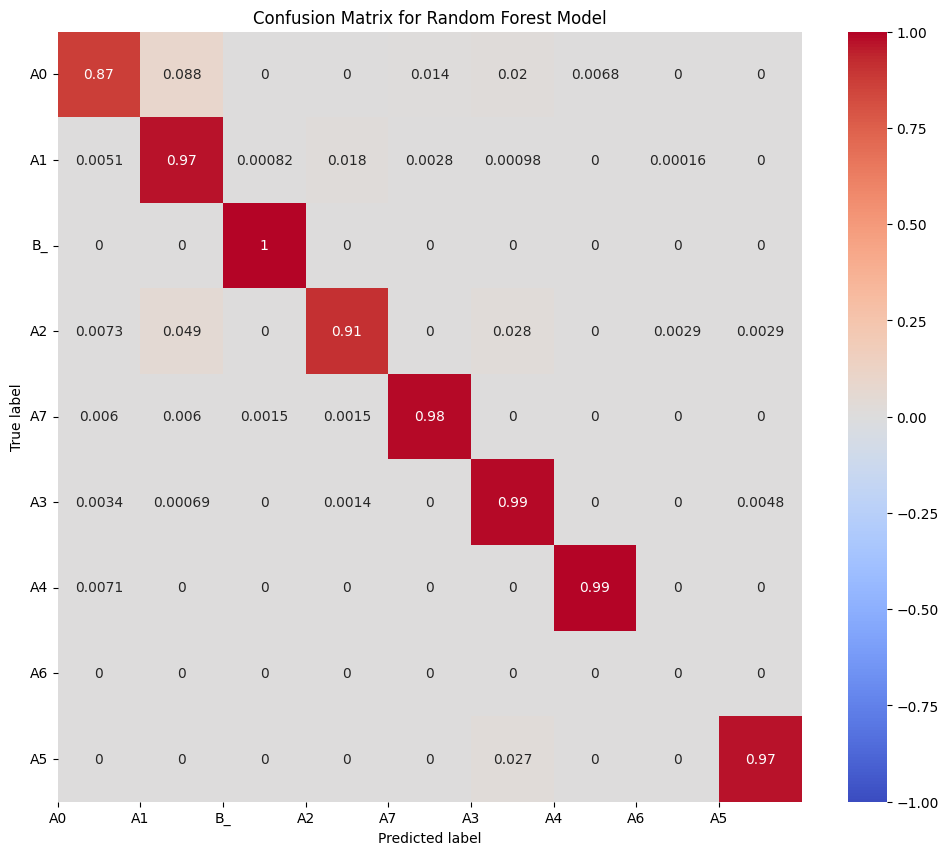

In [339]:

plt.figure(figsize=(12, 10))
sns.heatmap(matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=0)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

In [340]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.87      0.70      0.77       184
         1.0       0.97      0.99      0.98      6032
         2.0       1.00      0.77      0.87        26
         3.0       0.91      0.92      0.91      1354
        10.0       0.98      0.97      0.98       672
        14.0       0.99      0.98      0.99      2939
        15.0       0.99      0.99      0.99       141
        16.0       0.00      0.00      0.00         5
        20.0       0.97      0.86      0.91       128

    accuracy                           0.97     11481
   macro avg       0.85      0.80      0.82     11481
weighted avg       0.97      0.97      0.97     11481



/Users/lukewilsen/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/lukewilsen/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/lukewilsen/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

In [342]:
import pickle

with open("rf_best_mod.pkl","wb") as f:
    pickle.dump(rf_random.best_estimator_, f)